# Tutorial - Using YData Synthetics to improve a fraud dataset and deploy it to UbiOps

## Dealing with massively imbalanced datasets for improved fraud detection in the banking sector.

Use of synthetic data generation to balance highly imbalanced classes, in particular, generation of synthetic fraudulent events.

The use of synthetic data for this type of use cases helps to improve the accuracy of fraud detection models in many different areas from the banking industry.


### Machine Learning and imbalanced datasets
Highly imbalanced datasets are extremely challenging for data teams, and they can be found very often in the industry, wether in topics such as detecting fraudulent events, but also for money laundry and even credit underwriting.

The commonnality between each one of these use cases? The fact that only a small portion of the overall transactions represent one particular class, for fraud problems, only a portion of those transactions were, in reality, a fraudulent event.

## Credit Fraud - a highy imbalanced dataset
The dataset in this example use case is from Kaggle - ["Credit Card Fraud detection"](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset, as for demonstration purposes we are only able to use datasets from the public domain.
This dataset includes labeled transactions from European credit car holders, and the data provided is a result from a dimensionality reduction, containing 27 continous features and a time column - the number of secons elapsed between the first and the last transaction of the dataset.

### The dataset Exploratory data analysis
(Include here some input on how highly imbalanced are the datasets)

(Include here some metrics and some validations that where done using YData's lib for data analysis)


In [15]:
#Download the data from kaggle and read it using pandas
from datetime import datetime
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import pandas as pd

In [16]:
#Get the dataset right from kaggle
#Make sure that you've already downloaded your kaggle.json file and have eit located in the configured directoy for kaggle lib
#import kaggle
#kaggle.api.authenticate()
#kaggle.api.dataset_download_files('creditcardfraud', path='./data/', unzip=True)

credit = pd.read_csv('data/creditcard.csv')

In [17]:
credit.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

This dataset is highly imbalanced. Let's check the behaviour of the imbalanced classes.

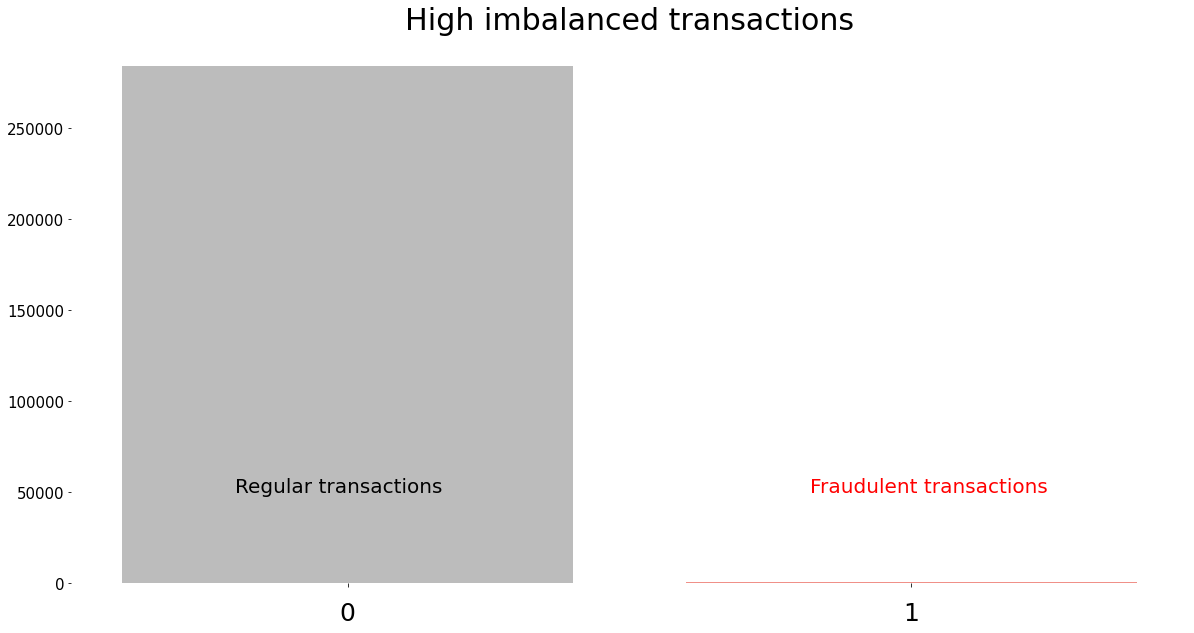

In [18]:
fig, ax = plt.subplots(figsize=(20,10))

#Remove the frame around
#Have this as an auxiliary function
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.bar([0, 1], pd.value_counts(credit['Class'].values, sort=True), alpha=0.5, color=['#7A7A7A','#E32212'])
plt.title('High imbalanced transactions', fontsize=30, pad=10)
plt.annotate('Fraudulent transactions', (0.82, 50000), fontsize=20, color='red')
plt.annotate('Regular transactions', (-0.2, 50000), fontsize=20, color='black')
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_ticks([0,1])
ax.tick_params(axis='x', which='major', pad=15)
ax.xaxis.set_tick_params(labelsize=25)

Text(0.5, 1.0, 'Scatter plot for V2 and V4 eigenvectors')

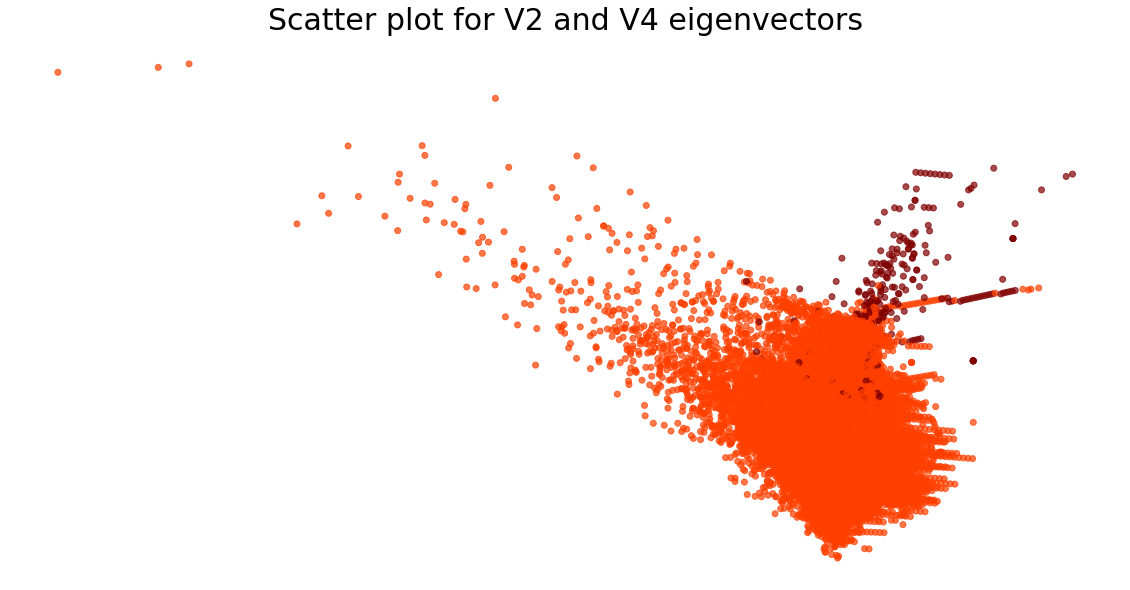

In [19]:
#Scatter plot with Class colouring the different elements from the plot
#As this dataset is the result of a PCA we will be using 2 eigen vectors for the plot
import matplotlib as m
import numpy as np

cmap = m.cm.jet(np.linspace(0,1,26))
cmap = m.colors.ListedColormap(cmap[21:,:-1])

fig, ax = plt.subplots(figsize=(20,10))

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.scatter(credit['V2'],credit['V4'], alpha=0.7, c=credit['Class'],cmap=cmap)
plt.axis('off')
plt.title('Scatter plot for V2 and V4 eigenvectors', fontsize=30, pad=10)

Splitting the dataset in train and test sets. The test set will be used again at the end of our iteration

In [20]:
X = credit.drop('Class', axis=1)
cols = X.columns
X = X.values
y = credit['Class']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807


In [21]:
count_original = np.unique(y, return_counts=True)
count_train = np.unique(y_train, return_counts=True)
count_test = np.unique(y_test, return_counts=True)

print("Ratio between fraud and normal events for the \033[1mfull\033[0m  dataset:"+ " {:.2}%".format(count_train[1][1]/count_train[1][0]))
print("Ratio between fraud and normal events for the \033[1mtrain\033[0m dataset:"+ " {:.2}%".format(count_train[1][1]/count_train[1][0]))
print("Ratio between fraud and normal events for the \033[1mtest\033[0m dataset:"+" {:.2}%".format(count_test[1][1]/count_test[1][0]))

Ratio between fraud and normal events for the full  dataset: 0.0017%
Ratio between fraud and normal events for the train dataset: 0.0017%
Ratio between fraud and normal events for the test dataset: 0.0017%


### The first model
Let's try to develop a model basedo n the assumption that everything is ok with our dataset, and understand how good is our classifier to indetify fraudulent events.
Here we've decided to develop a classifier using [RandomForest from the scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) package.

In [22]:
X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)

In [23]:
#Data scaling and preprocessing before training the model
from sklearn.preprocessing import RobustScaler, StandardScaler

def preprocess_df(df, std_scaler, rob_scaler):
    df['Amount'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
    df['Time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
    return df

In [24]:
stdscaler = StandardScaler()
robscaler = RobustScaler()

X_train = preprocess_df(X_train, stdscaler, robscaler)

In [25]:
#Apply the same trasnformation to the test dataset
X_test = preprocess_df(X_test, stdscaler, robscaler)

In [28]:
#Using XGBOOST model to train the model
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier


def XGBoost_Classifier(X, y, Xtest):
    """XGBoost training code"""
    classifier = XGBClassifier()
    print('Start fitting XGBoost classifier')
    classifier.fit(X, y)
    y_pred = classifier.predict(Xtest)
    print('Classifier trained.')
    return classifier, y_pred

classifier_model, y_pred = XGBoost_Classifier(X_train, y_train, X_test)

Start fitting XGBoost classifier


/home/fabiana/miniconda3/envs/ydata_synth/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:25:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classifier trained.


In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Print precision / recall report
print('Overall accuracy score :',accuracy_score(y_test, y_pred))
print('Classifier performance report: ')
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))

Overall accuracy score : 0.9995318516437859
Classifier performance report: 
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85296
       Fraud       0.96      0.76      0.85       147

    accuracy                           1.00     85443
   macro avg       0.98      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443



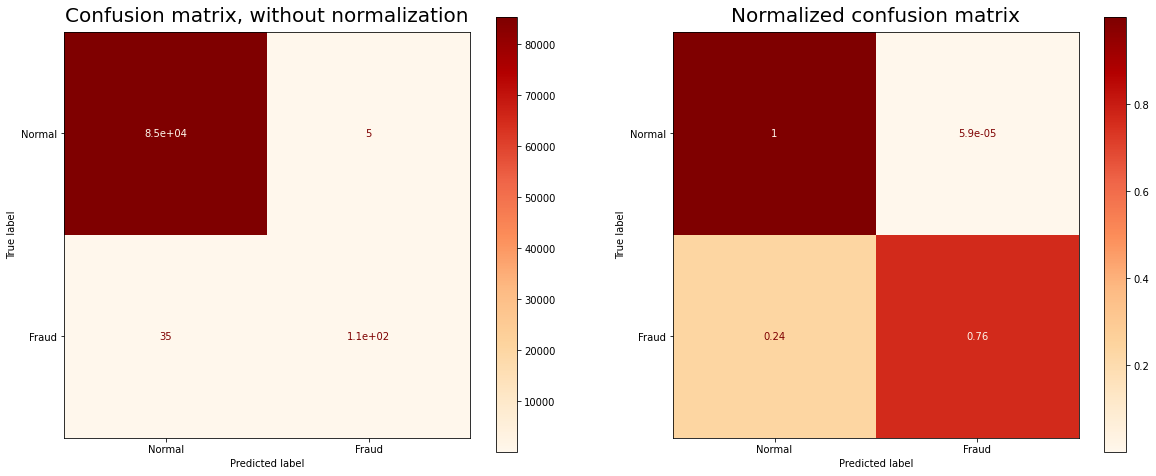

In [30]:
#Now let's check the real metrics for this classifier
from sklearn.metrics import plot_confusion_matrix


def print_confusion_matrix(model, X_test, y_test):
    """ Plot normalized and non-normalized confusion matrices """
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]

    fig, axes = plt.subplots(1,2,figsize=(20,8))
    for (title, normalize), ax in zip(titles_options, axes):

        disp = plot_confusion_matrix(model, X_test, y_test,
                                     display_labels=["Normal", "Fraud"],
                                     cmap=plt.cm.OrRd,
                                     normalize=normalize,
                                     ax=ax)

        ax.set_title(title, fontsize=20, pad=10)

print_confusion_matrix(classifier_model, X_test, y_test)

## Synthetic data to improve the detection of fraud

### Synthetic data with YData synthesizer package

In this case the objective is to synthesize only the fraudulent events. Through the augmentation of fraudulent events we are able to improve the results the results of our classifier.

In [31]:
#Let's filter by fraudulent events only
aux = X_train.copy()
aux['y'] = y_train.reset_index()['Class']

non_fraud = aux[aux['y'] == 0]
fraud = aux[aux['y']==1]

del aux

In [64]:
#Have here YData's lib to be called and used in the Jupyter Notebook
from ydata_synthetic.synthesizers.regular import WGAN_GP

noise_dim = 32
dim = 128
batch_size = 164

log_step = 100
epochs = 1000+1
learning_rate = 5e-4
beta_1 = 0.5
beta_2 = 0.9
models_dir = './cache'

gan_args = [batch_size, learning_rate, beta_1, beta_2, noise_dim, fraud.shape[1]-1, dim]
train_args = ['', epochs, log_step]

fraud_synth = WGAN_GP(gan_args, n_critic=2)
fraud_synth.train(fraud.drop('y', axis=1), train_args)

synthetic_fraud = fraud_synth.sample(400)
synthetic_fraud.columns = fraud.drop('y', axis=1).columns

  2%|▏         | 25/1001 [00:00<00:26, 37.44it/s]

Iteration: 0 | disc_loss: 15.979802131652832 | gen_loss: -0.013314387761056423
Iteration: 1 | disc_loss: 5.371106147766113 | gen_loss: -0.02528546005487442
Iteration: 2 | disc_loss: 2.6264243125915527 | gen_loss: -0.033514175564050674
Iteration: 3 | disc_loss: 1.3764173984527588 | gen_loss: -0.038931772112846375
Iteration: 4 | disc_loss: 0.512539267539978 | gen_loss: -0.043158791959285736
Iteration: 5 | disc_loss: 0.43702232837677 | gen_loss: -0.03998264670372009
Iteration: 6 | disc_loss: 0.2917519211769104 | gen_loss: -0.032349128276109695
Iteration: 7 | disc_loss: 0.18801504373550415 | gen_loss: -0.027961809188127518
Iteration: 8 | disc_loss: 0.11467933654785156 | gen_loss: -0.04328213259577751
Iteration: 9 | disc_loss: 0.0839921236038208 | gen_loss: -0.044397540390491486
Iteration: 10 | disc_loss: -0.058036863803863525 | gen_loss: -0.05219985172152519
Iteration: 11 | disc_loss: -0.5562556982040405 | gen_loss: -0.04804797098040581
Iteration: 12 | disc_loss: -0.5723077058792114 | gen_

  8%|▊         | 84/1001 [00:01<00:07, 127.38it/s]

Iteration: 48 | disc_loss: -0.6020193099975586 | gen_loss: -0.040809109807014465
Iteration: 49 | disc_loss: -0.6809402108192444 | gen_loss: 0.0038435491733253
Iteration: 50 | disc_loss: -0.6762475967407227 | gen_loss: 0.047171737998723984
Iteration: 51 | disc_loss: -0.46345898509025574 | gen_loss: -0.0294694434851408
Iteration: 52 | disc_loss: -0.6823751330375671 | gen_loss: 0.013673676177859306
Iteration: 53 | disc_loss: -0.7773761749267578 | gen_loss: 0.02976282685995102
Iteration: 54 | disc_loss: -0.7448337078094482 | gen_loss: 0.06738823652267456
Iteration: 55 | disc_loss: -0.7262330651283264 | gen_loss: -0.05318005010485649
Iteration: 56 | disc_loss: -0.7140597105026245 | gen_loss: -0.04359932988882065
Iteration: 57 | disc_loss: -0.7282890677452087 | gen_loss: 0.1578776240348816
Iteration: 58 | disc_loss: -0.7486377358436584 | gen_loss: 0.08090335875749588
Iteration: 59 | disc_loss: -0.700875461101532 | gen_loss: 0.06635863333940506
Iteration: 60 | disc_loss: -0.6927321553230286 |

 14%|█▍        | 145/1001 [00:01<00:04, 200.58it/s]

Iteration: 109 | disc_loss: -0.7124814987182617 | gen_loss: 0.3568502962589264
Iteration: 110 | disc_loss: -0.6974480748176575 | gen_loss: 0.2884252965450287
Iteration: 111 | disc_loss: -0.7695621848106384 | gen_loss: 0.20745056867599487
Iteration: 112 | disc_loss: -0.6716267466545105 | gen_loss: 0.06506208330392838
Iteration: 113 | disc_loss: -0.7219181656837463 | gen_loss: 0.05961899086833
Iteration: 114 | disc_loss: -0.6956722736358643 | gen_loss: 0.23701776564121246
Iteration: 115 | disc_loss: -0.6661866307258606 | gen_loss: 0.4031055271625519
Iteration: 116 | disc_loss: -0.7407289147377014 | gen_loss: 0.28606927394866943
Iteration: 117 | disc_loss: -0.72873854637146 | gen_loss: -0.03445545211434364
Iteration: 118 | disc_loss: -0.7059385776519775 | gen_loss: 0.41354596614837646
Iteration: 119 | disc_loss: -0.7359938025474548 | gen_loss: 0.1933838278055191
Iteration: 120 | disc_loss: -0.7028834819793701 | gen_loss: -0.10281524062156677
Iteration: 121 | disc_loss: -0.6298720836639404

 21%|██        | 208/1001 [00:01<00:03, 248.89it/s]

Iteration: 173 | disc_loss: -0.6026778221130371 | gen_loss: 0.07219991087913513
Iteration: 174 | disc_loss: -0.6433134078979492 | gen_loss: -0.08926065266132355
Iteration: 175 | disc_loss: -0.6664568781852722 | gen_loss: -0.49587687849998474
Iteration: 176 | disc_loss: -0.6570760011672974 | gen_loss: -0.47855809330940247
Iteration: 177 | disc_loss: -0.6456790566444397 | gen_loss: -0.14910244941711426
Iteration: 178 | disc_loss: -0.37375062704086304 | gen_loss: 0.037942931056022644
Iteration: 179 | disc_loss: -0.5759531855583191 | gen_loss: 0.16352400183677673
Iteration: 180 | disc_loss: -0.6335345506668091 | gen_loss: 0.13055409491062164
Iteration: 181 | disc_loss: -0.4828123152256012 | gen_loss: -0.14823345839977264
Iteration: 182 | disc_loss: -0.5404331088066101 | gen_loss: -0.28811803460121155
Iteration: 183 | disc_loss: -0.5891019701957703 | gen_loss: -0.30175119638442993
Iteration: 184 | disc_loss: -0.5947139263153076 | gen_loss: -0.2894344925880432
Iteration: 185 | disc_loss: -0.

 28%|██▊       | 281/1001 [00:01<00:02, 302.08it/s]

Iteration: 239 | disc_loss: -0.4008370637893677 | gen_loss: -0.0718250423669815
Iteration: 240 | disc_loss: -0.4920025169849396 | gen_loss: -0.13739663362503052
Iteration: 241 | disc_loss: -0.4411231577396393 | gen_loss: -0.22732625901699066
Iteration: 242 | disc_loss: -0.5017416477203369 | gen_loss: -0.3833596408367157
Iteration: 243 | disc_loss: -0.452871710062027 | gen_loss: -0.4394705295562744
Iteration: 244 | disc_loss: -0.46944913268089294 | gen_loss: -0.1853090077638626
Iteration: 245 | disc_loss: -0.49206283688545227 | gen_loss: -0.11681979894638062
Iteration: 246 | disc_loss: -0.48443061113357544 | gen_loss: -0.04222956672310829
Iteration: 247 | disc_loss: -0.48928576707839966 | gen_loss: 0.00037175053148530424
Iteration: 248 | disc_loss: -0.38080310821533203 | gen_loss: -0.10349161922931671
Iteration: 249 | disc_loss: -0.4514744281768799 | gen_loss: -0.20663589239120483
Iteration: 250 | disc_loss: -0.4939635396003723 | gen_loss: -0.3465452790260315
Iteration: 251 | disc_loss:

 35%|███▌      | 351/1001 [00:01<00:02, 313.71it/s]

Iteration: 303 | disc_loss: -0.3417282998561859 | gen_loss: -0.0923864096403122
Iteration: 304 | disc_loss: -0.37251707911491394 | gen_loss: -0.03503570333123207
Iteration: 305 | disc_loss: -0.2387004792690277 | gen_loss: -0.12418852746486664
Iteration: 306 | disc_loss: -0.367635041475296 | gen_loss: -0.06668604165315628
Iteration: 307 | disc_loss: -0.36027470231056213 | gen_loss: -0.050691355019807816
Iteration: 308 | disc_loss: -0.40591689944267273 | gen_loss: 0.022756587713956833
Iteration: 309 | disc_loss: -0.36361458897590637 | gen_loss: -0.015008577145636082
Iteration: 310 | disc_loss: -0.39141398668289185 | gen_loss: 0.3032223880290985
Iteration: 311 | disc_loss: -0.34222331643104553 | gen_loss: 0.00796832237392664
Iteration: 312 | disc_loss: -0.3541325628757477 | gen_loss: -0.21629038453102112
Iteration: 313 | disc_loss: -0.31376105546951294 | gen_loss: -0.04897715523838997
Iteration: 314 | disc_loss: -0.38421040773391724 | gen_loss: -0.06342314183712006
Iteration: 315 | disc_l

 42%|████▏     | 422/1001 [00:02<00:01, 326.20it/s]

Iteration: 375 | disc_loss: -0.2287069857120514 | gen_loss: -0.08636744320392609
Iteration: 376 | disc_loss: -0.3861415982246399 | gen_loss: 0.09123536944389343
Iteration: 377 | disc_loss: -0.3909348249435425 | gen_loss: 0.18268029391765594
Iteration: 378 | disc_loss: -0.3223324716091156 | gen_loss: 0.21491588652133942
Iteration: 379 | disc_loss: -0.3927766680717468 | gen_loss: 0.2805623412132263
Iteration: 380 | disc_loss: -0.4188377857208252 | gen_loss: 0.40793412923812866
Iteration: 381 | disc_loss: -0.33194205164909363 | gen_loss: 0.07342410087585449
Iteration: 382 | disc_loss: -0.37593895196914673 | gen_loss: -0.23099853098392487
Iteration: 383 | disc_loss: -0.36087071895599365 | gen_loss: -0.16073563694953918
Iteration: 384 | disc_loss: -0.39139634370803833 | gen_loss: -0.06045173853635788
Iteration: 385 | disc_loss: -0.3902263343334198 | gen_loss: 0.09036190062761307
Iteration: 386 | disc_loss: -0.4065086245536804 | gen_loss: 0.11538205295801163
Iteration: 387 | disc_loss: -0.39

 49%|████▉     | 495/1001 [00:02<00:01, 342.66it/s]

Iteration: 444 | disc_loss: -0.3697344660758972 | gen_loss: -0.11129775643348694
Iteration: 445 | disc_loss: -0.3384315073490143 | gen_loss: -0.08659258484840393
Iteration: 446 | disc_loss: -0.29998332262039185 | gen_loss: -0.18268930912017822
Iteration: 447 | disc_loss: -0.3399522304534912 | gen_loss: -0.06820180267095566
Iteration: 448 | disc_loss: -0.3433113396167755 | gen_loss: 0.060417499393224716
Iteration: 449 | disc_loss: -0.29600685834884644 | gen_loss: 0.24060457944869995
Iteration: 450 | disc_loss: -0.30159080028533936 | gen_loss: 0.18962189555168152
Iteration: 451 | disc_loss: -0.34702304005622864 | gen_loss: 0.28614145517349243
Iteration: 452 | disc_loss: -0.3138485252857208 | gen_loss: 0.07211131602525711
Iteration: 453 | disc_loss: -0.3850153386592865 | gen_loss: -0.032490331679582596
Iteration: 454 | disc_loss: -0.4036892056465149 | gen_loss: 0.15239231288433075
Iteration: 455 | disc_loss: -0.4008665978908539 | gen_loss: 0.12557344138622284
Iteration: 456 | disc_loss: -

 56%|█████▋    | 564/1001 [00:02<00:01, 332.59it/s]

Iteration: 512 | disc_loss: -0.28854647278785706 | gen_loss: 0.1409212350845337
Iteration: 513 | disc_loss: -0.4023725390434265 | gen_loss: -0.020130988210439682
Iteration: 514 | disc_loss: -0.34345555305480957 | gen_loss: 0.16565778851509094
Iteration: 515 | disc_loss: -0.3643796443939209 | gen_loss: 0.28309366106987
Iteration: 516 | disc_loss: -0.38880226016044617 | gen_loss: 0.2552191913127899
Iteration: 517 | disc_loss: -0.3123839497566223 | gen_loss: 0.2175023853778839
Iteration: 518 | disc_loss: -0.32557016611099243 | gen_loss: 0.13844212889671326
Iteration: 519 | disc_loss: -0.3293638229370117 | gen_loss: 0.27118951082229614
Iteration: 520 | disc_loss: -0.4242295026779175 | gen_loss: 0.20527546107769012
Iteration: 521 | disc_loss: -0.36348316073417664 | gen_loss: 0.24805209040641785
Iteration: 522 | disc_loss: -0.36055493354797363 | gen_loss: 0.25592443346977234
Iteration: 523 | disc_loss: -0.30191338062286377 | gen_loss: 0.20693476498126984
Iteration: 524 | disc_loss: -0.365156

 63%|██████▎   | 631/1001 [00:02<00:01, 316.04it/s]

Iteration: 579 | disc_loss: -0.3357352614402771 | gen_loss: -0.25692397356033325
Iteration: 580 | disc_loss: -0.3290727436542511 | gen_loss: -0.04670632630586624
Iteration: 581 | disc_loss: -0.3789631128311157 | gen_loss: 0.36297640204429626
Iteration: 582 | disc_loss: -0.35771214962005615 | gen_loss: 0.5397399663925171
Iteration: 583 | disc_loss: -0.34810325503349304 | gen_loss: 0.8761056065559387
Iteration: 584 | disc_loss: -0.3337933421134949 | gen_loss: 0.6851333379745483
Iteration: 585 | disc_loss: -0.28547805547714233 | gen_loss: 0.35122156143188477
Iteration: 586 | disc_loss: -0.3384930491447449 | gen_loss: 0.2974526584148407
Iteration: 587 | disc_loss: -0.3692782521247864 | gen_loss: 0.07229236513376236
Iteration: 588 | disc_loss: -0.3221537172794342 | gen_loss: -0.09867771714925766
Iteration: 589 | disc_loss: -0.3301205635070801 | gen_loss: -0.059026844799518585
Iteration: 590 | disc_loss: -0.2719089090824127 | gen_loss: 0.06960014998912811
Iteration: 591 | disc_loss: -0.31076

 70%|██████▉   | 699/1001 [00:02<00:00, 316.75it/s]

Iteration: 632 | disc_loss: -0.32124143838882446 | gen_loss: 0.373949259519577
Iteration: 633 | disc_loss: -0.3874870836734772 | gen_loss: 0.2437075823545456
Iteration: 634 | disc_loss: -0.3661087155342102 | gen_loss: 0.24676178395748138
Iteration: 635 | disc_loss: -0.3236364424228668 | gen_loss: 0.22063048183918
Iteration: 636 | disc_loss: -0.3864805996417999 | gen_loss: 0.17930729687213898
Iteration: 637 | disc_loss: -0.34297865629196167 | gen_loss: 0.1389036327600479
Iteration: 638 | disc_loss: -0.40599462389945984 | gen_loss: 0.03898990526795387
Iteration: 639 | disc_loss: -0.392783522605896 | gen_loss: 0.12895427644252777
Iteration: 640 | disc_loss: -0.3450751006603241 | gen_loss: 0.38961341977119446
Iteration: 641 | disc_loss: -0.3858341872692108 | gen_loss: 0.5605464577674866
Iteration: 642 | disc_loss: -0.35670924186706543 | gen_loss: 0.5137781500816345
Iteration: 643 | disc_loss: -0.39068132638931274 | gen_loss: 0.46614259481430054
Iteration: 644 | disc_loss: -0.36876118183135

 77%|███████▋  | 766/1001 [00:03<00:00, 320.11it/s]

Iteration: 701 | disc_loss: -0.3801911175251007 | gen_loss: 0.2079564779996872
Iteration: 702 | disc_loss: -0.3348485827445984 | gen_loss: 0.31217506527900696
Iteration: 703 | disc_loss: -0.3708949387073517 | gen_loss: 0.2879680395126343
Iteration: 704 | disc_loss: -0.3873664438724518 | gen_loss: 0.34358564019203186
Iteration: 705 | disc_loss: -0.3990533947944641 | gen_loss: 0.3569997549057007
Iteration: 706 | disc_loss: -0.4629015624523163 | gen_loss: 0.3163316249847412
Iteration: 707 | disc_loss: -0.37218549847602844 | gen_loss: 0.17796100676059723
Iteration: 708 | disc_loss: -0.3516004681587219 | gen_loss: 0.09024956077337265
Iteration: 709 | disc_loss: -0.31953737139701843 | gen_loss: 0.24468906223773956
Iteration: 710 | disc_loss: -0.3119364082813263 | gen_loss: 0.2770554721355438
Iteration: 711 | disc_loss: -0.37787729501724243 | gen_loss: 0.16858580708503723
Iteration: 712 | disc_loss: -0.382858544588089 | gen_loss: 0.24722228944301605
Iteration: 713 | disc_loss: -0.405271649360

 83%|████████▎ | 833/1001 [00:03<00:00, 313.66it/s]

Iteration: 770 | disc_loss: -0.37936335802078247 | gen_loss: 0.4414488971233368
Iteration: 771 | disc_loss: -0.3534083366394043 | gen_loss: 0.24563594162464142
Iteration: 772 | disc_loss: -0.41481274366378784 | gen_loss: 0.1893485188484192
Iteration: 773 | disc_loss: -0.4171242117881775 | gen_loss: 0.05274994298815727
Iteration: 774 | disc_loss: -0.46448612213134766 | gen_loss: -0.019631102681159973
Iteration: 775 | disc_loss: -0.31265789270401 | gen_loss: 0.2497287392616272
Iteration: 776 | disc_loss: -0.27710145711898804 | gen_loss: 0.1602766066789627
Iteration: 777 | disc_loss: -0.4495769441127777 | gen_loss: 0.15165358781814575
Iteration: 778 | disc_loss: -0.3811100423336029 | gen_loss: 0.19776825606822968
Iteration: 779 | disc_loss: -0.3103032410144806 | gen_loss: 0.3120063245296478
Iteration: 780 | disc_loss: -0.3503085970878601 | gen_loss: 0.4209820330142975
Iteration: 781 | disc_loss: -0.376620888710022 | gen_loss: 0.6427471041679382
Iteration: 782 | disc_loss: -0.3464784324169

 90%|████████▉ | 899/1001 [00:03<00:00, 319.74it/s]

Iteration: 833 | disc_loss: -0.36652928590774536 | gen_loss: 0.22942857444286346
Iteration: 834 | disc_loss: -0.4132782816886902 | gen_loss: 0.34780529141426086
Iteration: 835 | disc_loss: -0.3894389271736145 | gen_loss: 0.26967519521713257
Iteration: 836 | disc_loss: -0.3923857808113098 | gen_loss: 0.4019785225391388
Iteration: 837 | disc_loss: -0.3907895088195801 | gen_loss: 0.39653870463371277
Iteration: 838 | disc_loss: -0.31904926896095276 | gen_loss: 0.3982648253440857
Iteration: 839 | disc_loss: -0.3751274049282074 | gen_loss: 0.2919757068157196
Iteration: 840 | disc_loss: -0.3852815330028534 | gen_loss: 0.3555961549282074
Iteration: 841 | disc_loss: -0.4227622151374817 | gen_loss: 0.1983841061592102
Iteration: 842 | disc_loss: -0.3541657030582428 | gen_loss: 0.22702258825302124
Iteration: 843 | disc_loss: -0.403565913438797 | gen_loss: 0.174488365650177
Iteration: 844 | disc_loss: -0.44506803154945374 | gen_loss: 0.19572822749614716
Iteration: 845 | disc_loss: -0.36796924471855

 93%|█████████▎| 932/1001 [00:03<00:00, 312.99it/s]

Iteration: 899 | disc_loss: -0.3920351564884186 | gen_loss: 0.462833970785141
Iteration: 900 | disc_loss: -0.3815567195415497 | gen_loss: 0.4612271785736084
Iteration: 901 | disc_loss: -0.4751676321029663 | gen_loss: 0.6447294354438782
Iteration: 902 | disc_loss: -0.23220473527908325 | gen_loss: 0.63239586353302
Iteration: 903 | disc_loss: -0.42786192893981934 | gen_loss: 0.5217747092247009
Iteration: 904 | disc_loss: -0.33395469188690186 | gen_loss: 0.4503539800643921
Iteration: 905 | disc_loss: -0.3571488559246063 | gen_loss: 0.32896196842193604
Iteration: 906 | disc_loss: -0.37891557812690735 | gen_loss: 0.2770754098892212
Iteration: 907 | disc_loss: -0.36557579040527344 | gen_loss: 0.2833670675754547
Iteration: 908 | disc_loss: -0.4196068346500397 | gen_loss: 0.1889990270137787
Iteration: 909 | disc_loss: -0.26476457715034485 | gen_loss: 0.34456151723861694
Iteration: 910 | disc_loss: -0.38121798634529114 | gen_loss: 0.4199252128601074
Iteration: 911 | disc_loss: -0.303813964128494

Synthetic data generation: 100%|██████████| 3/3 [00:00<00:00, 473.24it/s]

Iteration: 962 | disc_loss: -0.4524153769016266 | gen_loss: 0.3066261112689972
Iteration: 963 | disc_loss: -0.36119478940963745 | gen_loss: 0.4372243285179138
Iteration: 964 | disc_loss: -0.3688276410102844 | gen_loss: 0.409517377614975
Iteration: 965 | disc_loss: -0.41645461320877075 | gen_loss: 0.3931356370449066
Iteration: 966 | disc_loss: -0.3893626034259796 | gen_loss: 0.6367059350013733
Iteration: 967 | disc_loss: -0.40956729650497437 | gen_loss: 0.5259668231010437
Iteration: 968 | disc_loss: -0.3670063614845276 | gen_loss: 0.5534073710441589
Iteration: 969 | disc_loss: -0.3921896815299988 | gen_loss: 0.44345250725746155
Iteration: 970 | disc_loss: -0.376936137676239 | gen_loss: 0.33480802178382874
Iteration: 971 | disc_loss: -0.39531099796295166 | gen_loss: 0.3298313617706299
Iteration: 972 | disc_loss: -0.38305774331092834 | gen_loss: 0.3926700949668884
Iteration: 973 | disc_loss: -0.3877250850200653 | gen_loss: 0.4160088300704956
Iteration: 974 | disc_loss: -0.3823120892047882

In [65]:
synthetic_fraud.head(5)

Time        V1        V2        V3        V4        V5        V6  \
0 -0.444033 -2.125528  1.860679 -2.120193  2.092186 -0.664325  0.920378   
1 -0.461279 -0.961934  1.798697 -1.322238  2.132613 -0.155134  0.590527   
2 -0.448583 -1.601101  1.308788 -1.960561  2.863233 -0.480108  0.321526   
3 -0.705238  0.465722  0.688836 -1.402667  3.407055 -0.119269 -0.086052   
4 -0.784608 -1.075127  1.736975 -4.724294  3.849954 -2.129241 -1.342408   

         V7        V8        V9  ...       V20       V21       V22       V23  \
0 -3.017955 -3.219932  0.840518  ... -0.751874  3.689034 -0.905844  0.626876   
1 -1.445085 -1.873708  1.108982  ... -0.704081  1.891209 -0.527480  0.099969   
2 -1.697537 -0.595535  1.130443  ... -0.439221  1.643746 -0.395081  0.460060   
3 -0.341757  0.011095  0.594161  ...  0.154462 -0.133849 -0.255220  0.070444   
4 -3.893043  1.426239 -0.268819  ...  0.714392  0.680136  0.335171  0.385233   

        V24       V25       V26       V27       V28    Amount  
0 -0.169111 -0.098870 -0.052105 -0.299068  0.342393 -0.157460  
1 -0.128057  0.098810 -0.033349 -0.094763  0.197499 -0.270825  
2 -0.119128 -0.100098 -0.006877 -0.566936  0.330989  0.103474  
3  0.018276  0.158307 -0.111998  0.043767  0.040579  0.201895  
4 -0.230477 -0.244927 -0.087590  0.162713  0.264948  0.246444  

[5 rows x 30 columns]

## Visualizing the generated synthetic data

In [66]:
#Read the synthetic fraud generated events 
#local_conn = LocalConnector()
#synthetic = local_conn.read_file('synthetic_fraud.csv', file_type=FileType.CSV)

synth_df = synthetic_fraud.copy()
org_df = X_train.copy()

org_df['Class'] = y_train.reset_index()['Class']
org_df['color'] = np.where(org_df['Class']==1, 2, 1)

synth_df['Class'] = 1
synth_df['color'] = 3

full_data = pd.concat([org_df, synth_df])

Using a PCA we are able to  reduce the dimensionality of the dataset and and better visualize the relation between both the synthetic fraud generated events and the ones from the original data, regardless they're fraud or normal events. 

The randomness introduced by the synthetic data can help the model to generalize for a new dataset and new fraud events never previously observed.

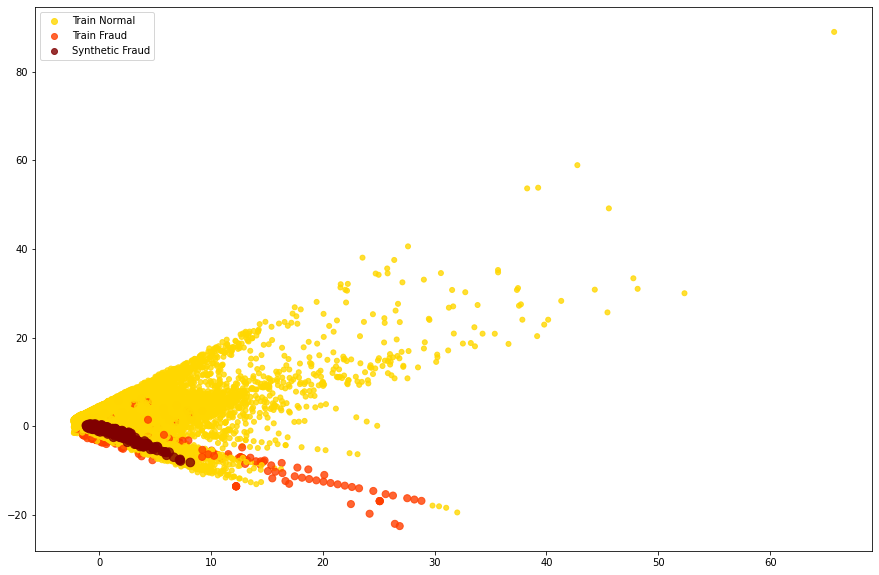

In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = full_data.iloc[:, :-2]
color = full_data['color']

fig = plt.figure(1, figsize=(15, 10))
plt.clf()
plt.cla()

cmap = m.cm.jet(np.linspace(0,1,26))
cmap = m.colors.ListedColormap(cmap[17:,:-1])

pca = PCA(n_components=2)
projected = pca.fit_transform(X)

labels = ['Train Normal', 'Train Fraud', 'Synthetic Fraud']

size_map = {1:25, 2:50, 3:75}
sizes = [size_map[x] for x in color]

scatter = plt.scatter(projected[:, 0], projected[:, 1],
                      s=sizes,
                      c=color,
                      cmap=cmap, 
                      alpha=0.8)

plt.legend(handles=scatter.legend_elements()[0], labels=labels)
plt.show()

### Testing the classifier capacity after adding more fraudulent events

In [68]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([85296,   147]))

In [69]:
synth_y_train = synth_df['Class']
synth_train = synth_df.drop(['Class', 'color'], axis=1)

X_augmented = pd.concat([X_train, synth_train], axis=0)
y_augmented = pd.concat([y_train, synth_y_train], axis=0)

In [70]:
synth_classmodel, y_pred = XGBoost_Classifier(X_augmented, y_augmented, X_test)

Start fitting XGBoost classifier


/home/fabiana/miniconda3/envs/ydata_synth/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:36:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classifier trained.


In [71]:
# Print precision / recall report
print('Overall accuracy score :',accuracy_score(y_test, y_pred))
print('Classifier performance report: ')
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))

Overall accuracy score : 0.9995669627705019
Classifier performance report: 
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85296
       Fraud       0.97      0.78      0.86       147

    accuracy                           1.00     85443
   macro avg       0.98      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443



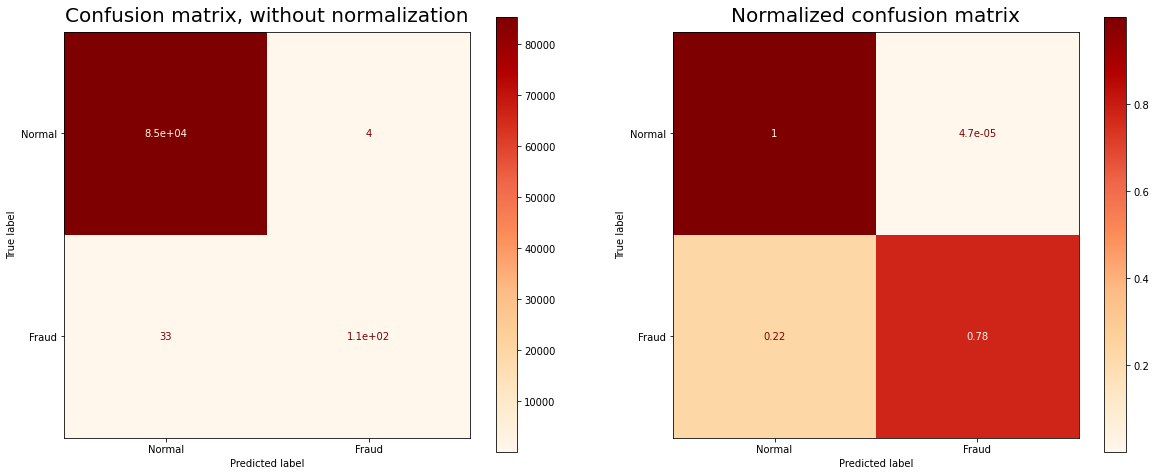

In [72]:
print_confusion_matrix(synth_classmodel, X_test, y_test)

In [2]:
#Create zip with deployment
filename = 'simple_deployment_package.zip'

## Deploy the model to UbiOps

In [ ]:
!pip install ubiops

In [6]:
import ubiops

API_TOKEN = 'Token <API TOKEN>'
PROJECT_NAME = 'ydata-to-ubiops'
DEPLOYMENT_NAME = 'ydata-tutorial'
DEPLOYMENT_VERSION = 'v1'

configuration = ubiops.Configuration()
configuration.api_key['Authorization'] = API_TOKEN

client = ubiops.ApiClient(configuration)
api = ubiops.api.CoreApi(client)

print(api.service_status())
client.close()

{'status': 'ok'}


In [14]:
deployment_template = ubiops.DeploymentCreate(
    name=DEPLOYMENT_NAME,
    description='XGBoost Fraud Detection',
    input_type='structured',
    output_type='structured',
    input_fields=[ubiops.DeploymentInputFieldCreate(name='input', data_type='double')],
    output_fields=[ubiops.DeploymentOutputFieldCreate(name='output', data_type='double')]
)

deployment = api.deployments_create(project_name=PROJECT_NAME, data=deployment_template)
print(deployment)

{'creation_date': datetime.datetime(2021, 1, 30, 19, 41, 50, 92238, tzinfo=tzlocal()),
 'description': 'XGBoost Fraud Detection',
 'id': 'be6a2df1-abd1-4266-9b45-5be171b9c5c4',
 'input_fields': [{'data_type': 'double', 'name': 'input'}],
 'input_type': 'structured',
 'labels': {},
 'last_updated': datetime.datetime(2021, 1, 30, 19, 41, 50, 92256, tzinfo=tzlocal()),
 'name': 'ydata-tutorial',
 'number_of_versions': '0',
 'output_fields': [{'data_type': 'double', 'name': 'output'}],
 'output_type': 'structured',
 'project': 'ydata-to-ubiops'}


In [15]:
version_template = ubiops.VersionCreate(
    version=DEPLOYMENT_VERSION,
    language='python3.7',
    memory_allocation=256,
    maximum_instances=1,
    minimum_instances=0,
    maximum_idle_time=1800 # = 30 minutes
)

version = api.versions_create(
    project_name=PROJECT_NAME,
    deployment_name=DEPLOYMENT_NAME,
    data=version_template
)
print(version)

{'creation_date': datetime.datetime(2021, 1, 30, 19, 41, 53, 956049, tzinfo=tzlocal()),
 'deployment': 'ydata-tutorial',
 'description': '',
 'error_message': None,
 'file_last_updated': datetime.datetime(2021, 1, 30, 19, 41, 53, 956031, tzinfo=tzlocal()),
 'id': 'c0834718-04e6-47fd-9981-dc973873f9b6',
 'labels': {},
 'language': 'python3.7',
 'last_updated': datetime.datetime(2021, 1, 30, 19, 41, 53, 956054, tzinfo=tzlocal()),
 'maximum_idle_time': 1800,
 'maximum_instances': 1,
 'memory_allocation': 256,
 'minimum_instances': 0,
 'status': 'initialised',
 'version': 'v1'}


In [16]:
file_upload_result =api.versions_file_upload(
    project_name=PROJECT_NAME,
    deployment_name=DEPLOYMENT_NAME,
    version=DEPLOYMENT_VERSION,
    file='simple_deployment_package.zip'
)

In [17]:
from time import sleep
status = 'building'
while status != 'available' and 'failed' not in status:    
    version_status = api.versions_get(       
        project_name=PROJECT_NAME,        
        deployment_name=DEPLOYMENT_NAME,        
        version=DEPLOYMENT_VERSION    
    )    
    status = version_status.status
    print(status, end='\r')
    sleep(1)
print(status)

available


In [19]:
# data = y_test
data = {'input': 123}
request_result = api.deployment_requests_create(
    project_name=PROJECT_NAME,
    deployment_name=DEPLOYMENT_NAME,
    version=DEPLOYMENT_VERSION,
    data=data
)
print(request_result)

{'error_message': '', 'result': {'output': 57.418105942159}, 'success': True}
